<a href="https://colab.research.google.com/github/kishanAk21/Image-Captioning/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Dependencies

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns
sns.set()
from collections import Counter
from nltk.corpus import stopwords

import keras
from sklearn.model_selection import train_test_split
import string
import os
import time
from PIL import Image
import glob
from pickle import dump, load
from time import time
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm

import gc
gc.collect()

0

In [2]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzipping file to Colab VM

!unzip -qq "gdrive/MyDrive/img_cap.zip" -d ""

# Data understanding


In [4]:
#Import the dataset and read the image into a seperate variable

images= 'Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
all_imgs[0:5]

['Images/1775029934_e1e96038a8.jpg',
 'Images/1184967930_9e29ce380d.jpg',
 'Images/2100816230_ff866fb352.jpg',
 'Images/2279496715_8ef3ee6edb.jpg',
 'Images/1089755335_0bfbfd30e6.jpg']

In [6]:
len(all_imgs)

8091

In [7]:
captions = pd.read_csv('captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
captions.shape

(40455, 2)

In [9]:
captions.image.nunique()

8091

In [10]:
captions['path'] = 'Images/' + captions.image
captions.head()

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,Images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,Images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,Images/1000268201_693b08cb0e.jpg


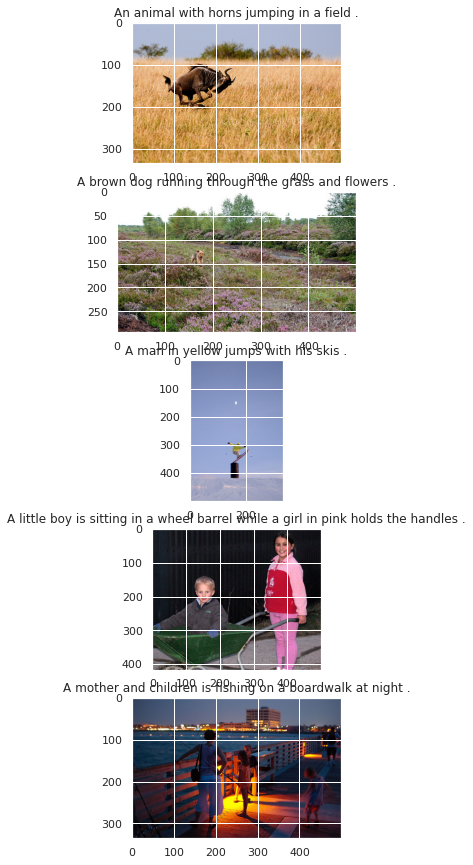

In [11]:
# Visualise both the images & text present in the dataset

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(15)


for i in range(5):
    img = Image.open(all_imgs[i])
    
    plt.subplot(5,1,i+1)
    plt.imshow(img)
    plt.title(captions[captions.image==all_imgs[i].split('/')[1]].caption.values[0])


In [12]:
# Create a list which contains all the captions
annotations=['<start> ' + sent + ' <end>' for sent in captions.caption]

# Create a list which contains all the path to the images
all_img_path = list(captions.path)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
annotations[0:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

# Pre-Processing the captions

In [14]:
num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [15]:
# Create tokenizer

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [16]:
# Get our training data word index
# tokenizer.word_index

In [17]:
index_seq = tokenizer.texts_to_sequences(annotations)
# index_seq[0:2]

In [18]:
 # Adding Padding

maxlen = max([len(sent) for sent in captions.caption.str.split()]) + 2
index_seq_padded = pad_sequences(index_seq, padding=pad_type,
                                 truncating=trunc_type, maxlen=maxlen)

index_seq_padded

array([[ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 42, ...,  0,  0,  0],
       ...,
       [ 3,  2, 46, ...,  0,  0,  0],
       [ 3,  2, 87, ...,  0,  0,  0],
       [ 3,  2, 87, ...,  0,  0,  0]], dtype=int32)

In [19]:
index_seq_padded.shape

(40455, 40)

# Create the train & test tf dataset objects

In [20]:
BUFFER_SIZE = 1000
img_height = 299
img_width = 299
batch_size = 32
img_dims = (img_height, img_width)
data_dir = 'Images/'

In [21]:
# Train-Test Split

img_train, img_test, cap_train, cap_test = train_test_split(all_img_path, index_seq_padded,
                                                            test_size=0.2,random_state=42)

In [22]:
# Creating tf batch dataset object

img_train = tf.constant(img_train)
img_test = tf.constant(img_test)

cap_train = tf.constant(cap_train)
cap_test = tf.constant(cap_test)


train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))


def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.image.resize(image_decoded, (img_height, img_width))
    image_decoded = preprocess_input(image_decoded)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

In [23]:
# tf batch dataset object

type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [24]:
train_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None, 40)), types: (tf.float32, tf.int32)>

In [25]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32, 40)


In [26]:
# Load the pretrained Imagenet weights of Inception net V3

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [27]:
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# Inception features extraction model
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

In [28]:
# Image --> Inception features


from tqdm import tqdm
from tqdm.notebook import tqdm

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path


encode_train = sorted(set(all_img_path))
feature_dict = {}
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)


for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    feature_dict[path_of_feature] =  bf.numpy()

  0%|          | 0/253 [00:00<?, ?it/s]

In [29]:
# Mapping to Feature Dictionary: image_name, Caption --> Image_tensor (inception features), Caption

def map_func(img_name, cap):
  img_tensor = feature_dict[img_name.decode('utf-8')]
  return img_tensor, cap

In [30]:
def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [31]:
train_dataset=gen_dataset(img_train,cap_train)
test_dataset=gen_dataset(img_test,cap_test)

In [32]:
# Checking for correct outputs

sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048) == Batch, Inception_features
print(sample_cap_batch.shape) #(batch_size,40) == Batch, Caption_index

(32, 64, 2048)
(32, 40)


# Model Building

Model Includes two components:

- `Encoder`: Encodes the features from `Inception` net into required size. It includes a dense layer.

- `Decoder`: Attention + GRU

  - `Attention`: It takes Encoder output and GRU hidden output (from previous time step) as input and gives context vector as output.

  - `GRU`: It takes GRU hidden and main outputs (from previous time step) and attention context vector as input and gives hidden and main outputs as result. 

In [33]:
embedding_dim = 256 
units = 512
vocab_size = 5001
train_num_steps = index_seq_padded.shape[0]*0.8// batch_size
test_num_steps = index_seq_padded.shape[0]*0.2// batch_size
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

## Encoder

In [34]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        features =  self.dense(features)
        
        return features

In [35]:
encoder=Encoder(embedding_dim)

## Attention model

In [36]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, axis=1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector =  attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

## Decoder

In [37]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)
        self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) 
        output, state = self.gru(embed, mask=mask) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output) 
        
        return output, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [38]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [39]:
# Checking the model outputs

features = encoder(sample_img_batch)

hidden = decoder.reset_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


# Model training & optimization


In [40]:
# Defining the Optimizer and Loss 

optimizer = tf.keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [41]:
# Loss function

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [42]:
# Saving model parameters while training

checkpoint_path = ''
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [44]:
# Defining the train step

@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    
    for i in range(1, target.shape[1]):
      output, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], output)
      dec_input = tf.expand_dims(target[:, i], 1)
      
  avg_loss = (loss / int(target.shape[1]))
    
  
  grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
  optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
  
  return loss, avg_loss

In [45]:
# Defining the test step

@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      output, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], output)
      dec_input = tf.expand_dims(tf.argmax(output, axis=1), 1)
      
    avg_loss = (loss / int(target.shape[1]))
    
    return avg_loss, loss

In [46]:
# Test loss

def test_loss_cal(test_dataset):
  total_loss = 0
  
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    batch_loss, t_loss = test_step(img_tensor, target)
    
    total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
  return avg_test_loss

In [47]:
import time

In [49]:
# Executing the Model training

loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.828, & test loss is 75.450
Time taken for 1 epoch 446.8570647239685 sec

Test loss has been reduced from 100.000 to 75.450
For epoch: 2, the train loss is 0.775, & test loss is 74.594
Time taken for 1 epoch 444.8641183376312 sec

Test loss has been reduced from 75.450 to 74.594
For epoch: 3, the train loss is 0.728, & test loss is 77.963
Time taken for 1 epoch 493.3037385940552 sec

For epoch: 4, the train loss is 0.685, & test loss is 78.397
Time taken for 1 epoch 446.3001160621643 sec

For epoch: 5, the train loss is 0.646, & test loss is 81.955
Time taken for 1 epoch 448.94797468185425 sec

For epoch: 6, the train loss is 0.608, & test loss is 81.875
Time taken for 1 epoch 491.0771243572235 sec

For epoch: 7, the train loss is 0.575, & test loss is 85.287
Time taken for 1 epoch 449.52928280830383 sec

For epoch: 8, the train loss is 0.544, & test loss is 87.550
Time taken for 1 epoch 449.4225857257843 sec

For epoch: 9, the train loss is 0.515, & te

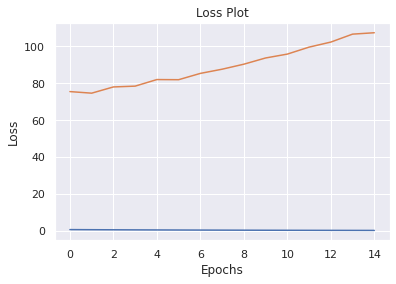

In [50]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Model Evaluation

### Greedy Search

In [51]:
def evaluate(image):
    attention_plot = np.zeros((maxlen, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(maxlen):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [52]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 20))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [53]:
from nltk.translate.bleu_score import sentence_bleu

In [54]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score: 28.867513459481287
Real Caption: a child throwing an orange toy
Prediction Caption: a young boy wearing a white hat reaches to catch a frisbee


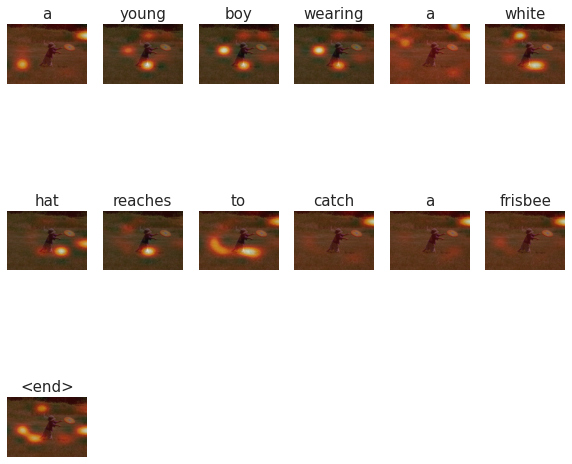

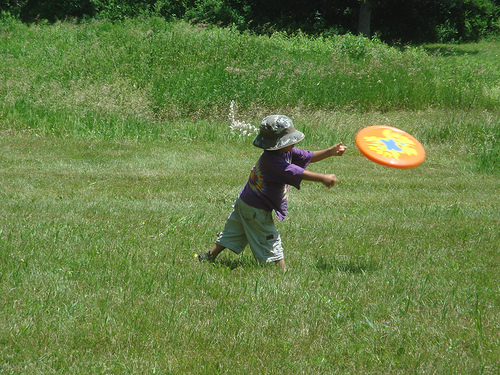

In [55]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
# test_image = ''
# real_caption = ''

real_caption = ' '.join([tokenizer.index_word[i.numpy()] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))
print(f"BELU score: {score*100}")
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image.numpy()) 
Image.open(test_image.numpy()) 
